## Descriptive Analysis

A notebook to describe the data set with simple statistical tools.

In [1]:
import pandas as pd
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_rel
from sklearn.feature_selection import SelectKBest, chi2
import random


import ml_colon

### Setting up Data Directory

In [2]:
data_dir = ml_colon.HERE.parents[2] / "data" 
print(data_dir)

assert data_dir.exists()

data_files = list(data_dir.glob("*.csv"))
print([f.name for f in data_files])

assert data_files

c:\users\tomva\documents\data_processes_mlcolonoscopy\data
['data_description.csv']


### Loading Raw Data

In [5]:
_filepath = data_dir / "raw_data.csv"
df = pd.read_csv(_filepath)

# assert all rows have been loaded
len(df) == sum(1 for i in open(_filepath)) -1 # file has header

print(f"Raw data set has: {len(df)} rows")

Raw data set has: 16000 rows


In [6]:
descr_df = pd.read_csv(data_dir / "data_description.csv", index_col="column_name")

In [7]:
print(descr_df)

                                                         description
column_name                                                         
quality              a measure of the quality of the recorded video.
bits               number of bits used to encode that block in th...
intra_parts        number sub-blocks inside this block that are n...
skip_parts         number sub-blocks inside this block that are s...
inter_16x16_parts  number of sub-blocks inside this block making ...
inter_4x4_parts    number of sub-blocks inside this block making ...
inter_other_parts  number of sub-blocks inside this block making ...
non_zero_pixels    number of pixels different from 0 after encodi...
frame_width                  the width of the video frame in pixels.
frame_height                the height of the video frame in pixels.
movement_level     a measure of the level of movement of this fra...
mean                        mean of the pixels of the encoded block.
sub_mean_1         mean of the pix

Let's take a quick look at the actual data.

In [8]:
df.head()

,quality,bits,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,non_zero_pixels,frame_width,frame_height,...,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2,relevant
0,22,2143,0,0,1,3,21,404,416,240,...,17.397461,17.397461,87.584335,2.820312,2.539062,10.772400,8.576599,0.0,0.0,1.0
1,22,1735,0,2,0,3,8,381,416,240,...,14.426758,14.233398,48.025330,1.843750,1.921875,6.163086,6.665771,8816.0,8801.0,1.0
2,22,1971,0,0,0,0,8,460,416,240,...,15.203125,13.953125,56.613480,3.000000,4.937500,1.625000,3.683594,5104.0,5193.0,1.0
3,22,2473,0,0,0,18,20,421,416,240,...,21.725586,29.165039,283.079285,2.078125,2.500000,25.806396,34.656250,21531.0,19802.0,1.0
4,22,1093,0,0,1,3,8,167,416,240,...,11.929688,14.353516,175.123245,3.070312,4.523438,22.252869,14.780701,15073.0,14549.0,1.0


Let's take a quick look at the datatypes in the dataframe

In [9]:
df.dtypes

quality                int64
bits                   int64
intra_parts            int64
skip_parts             int64
inter_16x16_parts      int64
inter_4x4_parts        int64
inter_other_parts      int64
non_zero_pixels        int64
frame_width            int64
frame_height           int64
movement_level         int64
mean                 float64
sub_mean_1           float64
sub_mean_2           float64
sub_mean_3           float64
sub_mean_4           float64
var_sub_blocks       float64
sobel_h              float64
sobel_v              float64
variance             float64
block_movement_h     float64
block_movement_v     float64
var_movement_h       float64
var_movement_v       float64
cost_1               float64
cost_2               float64
relevant             float64
dtype: object

Conclusion:
Looks like we are only dealing with numerical data (no characters, strings, datetimes, ...)

However, the int64 types seem to be discrete and may need special care.

### Missing Values?

Next, let's take a look if there are any Nulls, NaNs in the data set and if so how many.

In [10]:
_null_df = df.isnull().sum()

print(_null_df[_null_df > 0])

sub_mean_3    14
cost_2        17
relevant       2
dtype: int64


The missing values for sub_mean_3 and cost_2 maybe can be imputed / recovered. (or dropped since there are only 17 at most)

For the target variable "relevant" not. It's probably best to drop these 2 rows as we later also want to exclude them from training / testing the model and its only a total of 2 rows...

In [11]:
df = df[~df.relevant.isnull()]

len(df)

15998

### Column Analysis

We want to go over each variable in the dataset and explore it with simple descriptive statistics.

A first overview can be seen here:

In [12]:
df.describe()

,quality,bits,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,non_zero_pixels,frame_width,frame_height,...,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2,relevant
count,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,...,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15998.000000,15981.000000,15998.000000
mean,29.500938,449.697400,11.041380,0.849294,0.995499,1.977997,3.685273,74.059007,1432.075009,850.046256,...,8.027204,8.270743,53.333526,8.024506,6.797750,842.053206,491.974570,36943.436492,42055.148051,0.822353
std,5.590065,549.099212,19.051407,1.181890,1.018540,3.901329,4.445079,102.584098,851.931382,530.222216,...,9.184985,9.552621,107.271594,17.260686,11.552863,3815.457401,2404.213566,38630.539744,43844.993440,0.382227
min,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,416.000000,240.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,520.000000,300.000000,...,0.896240,0.943359,1.424382,0.500000,0.500000,0.687500,0.746094,9916.250000,10964.000000,1.000000
50%,32.000000,243.000000,0.000000,0.000000,1.000000,0.000000,2.000000,33.000000,1920.000000,1080.000000,...,5.170898,5.313477,14.525076,2.625000,3.214844,11.685547,19.544434,23048.500000,26132.000000,1.000000
75%,35.750000,622.000000,16.000000,1.000000,2.000000,3.000000,6.000000,100.000000,2400.000000,1470.000000,...,11.628906,11.776123,52.494077,7.062500,8.062500,94.125549,96.068176,52043.250000,59856.000000,1.000000
max,37.000000,4771.000000,64.000000,4.000000,4.000000,33.000000,27.000000,828.000000,2560.000000,1600.000000,...,69.706055,66.775391,2022.197998,322.093750,189.000000,194634.750000,68389.359375,425705.000000,446306.000000,1.000000


#### Column: Quality

a measure of the quality of the recorded video.


<AxesSubplot:ylabel='Count'>

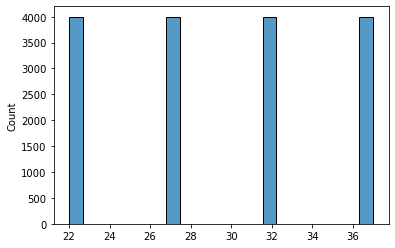

In [13]:
column_name = "quality"
print(descr_df.loc[column_name, "description"])

sns.histplot(df[column_name].values)

In [14]:
df[column_name].value_counts()

37    4000
27    4000
32    4000
22    3998
Name: quality, dtype: int64

Looks like a Discrete uniform distribution, but maybe data set was sampled in that way...


#### Column: Bits

In [15]:

column_name = "bits"
print(descr_df.loc[column_name, "description"])

number of bits used to encode that block in the video stream.


<AxesSubplot:title={'center':'Histogram of bits'}, ylabel='Count'>

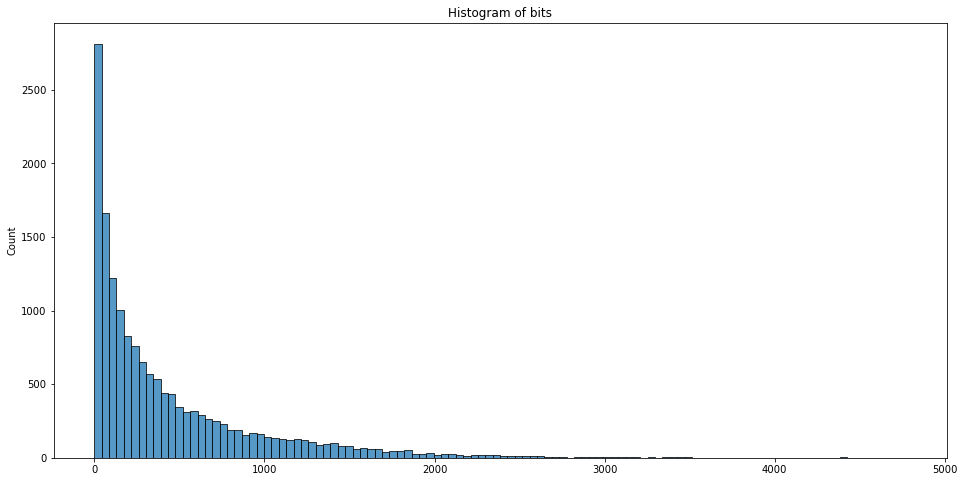

In [16]:

fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")

sns.histplot(df[column_name].values, ax=ax)

The distribution is highly skewed and it looks like most of the blocks are encoded using only a few bits.
This raises the question: Are there blocks that allegedly are encoded with 0 bits in the video stream?

Note: This should not be possible as 0 bits would mean 0 information in my opinion. 

Let's identify the characteristics of the rows whose value of "bits" is 0

In [17]:
df[df["bits"]==0].head()

,quality,bits,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,non_zero_pixels,frame_width,frame_height,...,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2,relevant
2312,32,0,0,4,0,0,0,0,416,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97086.0,106606.0,1.0
2571,32,0,0,4,0,0,0,0,416,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39157.0,41706.0,1.0
3614,37,0,0,4,0,0,0,0,416,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46928.0,14619.0,1.0
3672,37,0,0,4,0,0,0,0,416,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94751.0,139392.0,1.0
3675,37,0,0,4,0,0,0,0,416,240,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43672.0,57860.0,0.0


In [18]:
df[df["bits"]==0].sum()

quality              4.939000e+03
bits                 0.000000e+00
intra_parts          0.000000e+00
skip_parts           5.880000e+02
inter_16x16_parts    0.000000e+00
inter_4x4_parts      0.000000e+00
inter_other_parts    0.000000e+00
non_zero_pixels      0.000000e+00
frame_width          3.183680e+05
frame_height         1.930800e+05
movement_level       1.115301e+09
mean                 1.838281e+01
sub_mean_1           1.933203e+01
sub_mean_2           1.392188e+01
sub_mean_3           1.672656e+01
sub_mean_4           2.355078e+01
var_sub_blocks       4.743268e+01
sobel_h              5.641211e+01
sobel_v              5.796680e+01
variance             2.654711e+02
block_movement_h     0.000000e+00
block_movement_v     0.000000e+00
var_movement_h       0.000000e+00
var_movement_v       0.000000e+00
cost_1               2.591150e+06
cost_2               2.820001e+06
relevant             8.000000e+01
dtype: float64

When the value of <i>bits</i> is 0, <i>intra_parts, inter_16x16_parts, inter_4x4_parts, inter_other_parts, non_zero_pixels, block_movement_h, block_movement_v, var_movement_h, var_movement_v</i> are zero as well. So, what do they represent?

In [19]:
pd.options.display.max_colwidth = 200
descr_df.loc[df[df["bits"]==0].sum()==0]

,description
column_name,
bits,number of bits used to encode that block in the video stream.
intra_parts,number sub-blocks inside this block that are not encoded by making use of information in other frames.
inter_16x16_parts,number of sub-blocks inside this block making use of information in other frames and whose size is 16x16 pixels.
inter_4x4_parts,number of sub-blocks inside this block making use of information in other frames and whose size is 4x4 pixels.
inter_other_parts,number of sub-blocks inside this block making use of information in other frames and whose size is different from 16x16 and 4x4 pixels.
non_zero_pixels,number of pixels different from 0 after encoding the block.
block_movement_h,a measure of the movement of the current block in the horizontal direction.
block_movement_v,a measure of the movement of the current block in the vertical direction.
var_movement_h,a measure of the variance of the movements inside the current block in the horizontal direction.


In [20]:
print("Number of rows with 0 bits: ", len(df[df[column_name] ==0]))

Number of rows with 0 bits:  147


In [21]:
pd.cut(df[column_name], bins=[0, 8, 16, 32, 64, 124], include_lowest=False).value_counts(sort=False)

(0, 8]        696
(8, 16]       419
(16, 32]      964
(32, 64]     1494
(64, 124]    1818
Name: bits, dtype: int64

There are some block that are encoded with a very small number of bits. 696 rows are encoded with at most 8 bits. Will be interesting to see how quality depends on number of bits...For now we keep these rows but potentially these rows we have to deal with separately.

#### intra_parts

In [22]:
column_name = "intra_parts"
print(descr_df.loc[column_name, "description"])

number sub-blocks inside this block that are not encoded by making use of information in other frames.


<AxesSubplot:title={'center':'Histogram of intra_parts'}, ylabel='Count'>

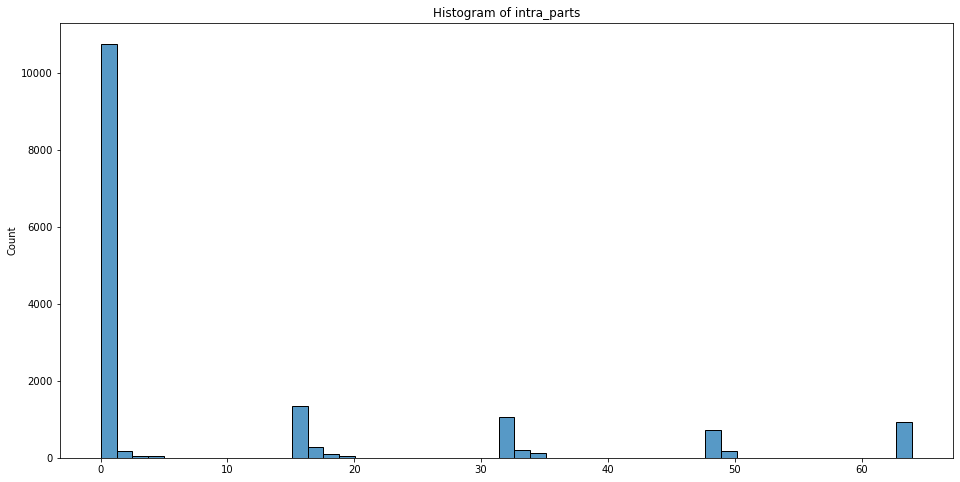

In [23]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")

sns.histplot(df[column_name].values, ax=ax)

In [24]:
df[column_name].value_counts(sort=False)

0     10310
16     1355
32     1060
48      718
64      919
1       440
17      280
33      198
49      176
2       177
18       97
34      115
3        45
19       55
4        53
Name: intra_parts, dtype: int64

The big majority of rows have 0 sub-blocks. Not sure if I yet understand what these sub-blocks are...

#### skip_parts

In [25]:
column_name = "skip_parts"
print(descr_df.loc[column_name, "description"])

number sub-blocks inside this block that are straight-forward copied from another frame.


<AxesSubplot:title={'center':'Histogram of skip_parts'}, xlabel='skip_parts', ylabel='Count'>

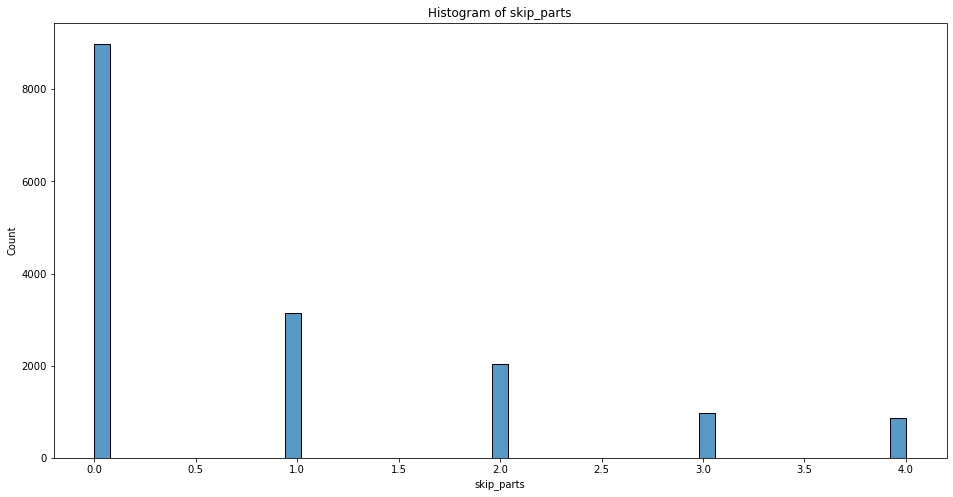

In [26]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### inter_16x16_parts

In [27]:
column_name = "inter_16x16_parts"
print(descr_df.loc[column_name, "description"])

number of sub-blocks inside this block making use of information in other frames and whose size is 16x16 pixels.


<AxesSubplot:title={'center':'Histogram of inter_16x16_parts'}, xlabel='inter_16x16_parts', ylabel='Count'>

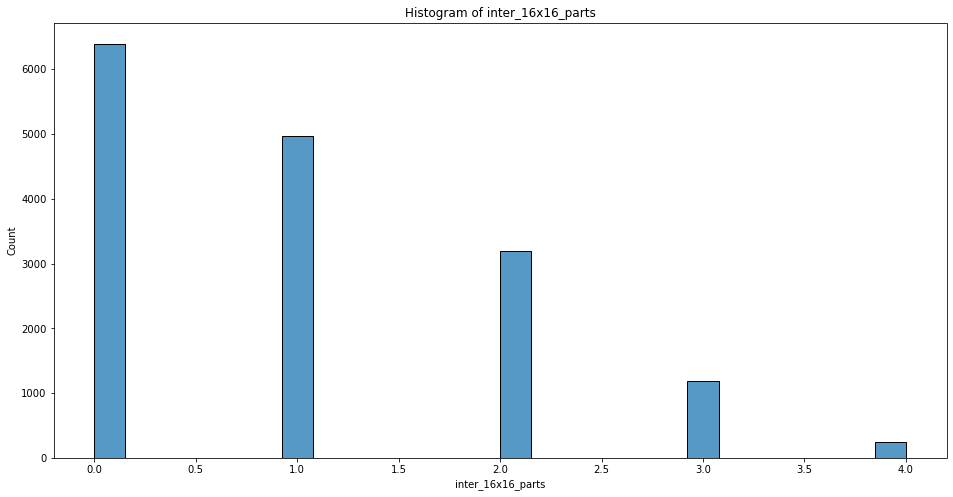

In [28]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

This is difficult to interpret. The description is not clear. 

#### Column: inter_4x4_parts

In [29]:
column_name = "inter_4x4_parts"
print(descr_df.loc[column_name, "description"])

number of sub-blocks inside this block making use of information in other frames and whose size is 4x4 pixels.


<AxesSubplot:title={'center':'Histogram of inter_4x4_parts'}, xlabel='inter_4x4_parts', ylabel='Count'>

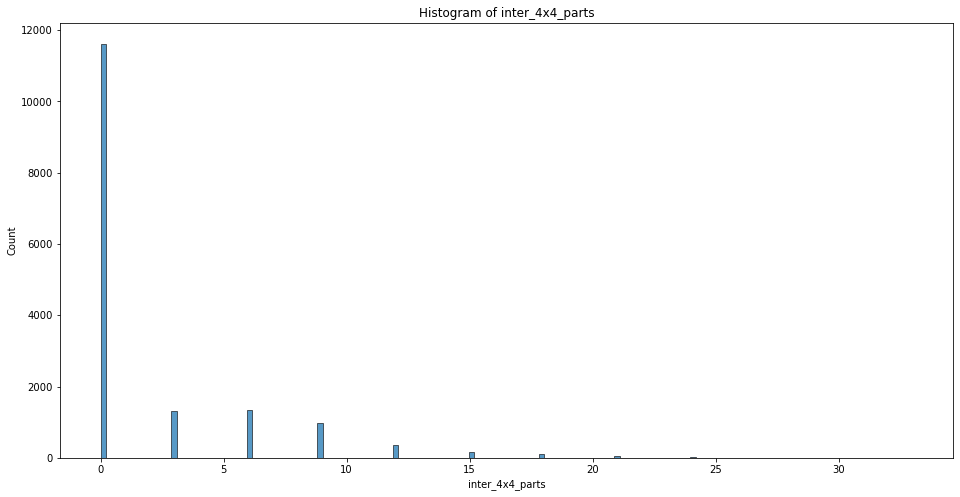

In [30]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

The above two plots have shown that bigger sub-blocks have less information overlap than small sub-blocks. 

#### inter_other_parts

In [31]:
column_name = "inter_other_parts"
print(descr_df.loc[column_name, "description"])

number of sub-blocks inside this block making use of information in other frames and whose size is different from 16x16 and 4x4 pixels.


<AxesSubplot:title={'center':'Histogram of inter_other_parts'}, xlabel='inter_other_parts', ylabel='Count'>

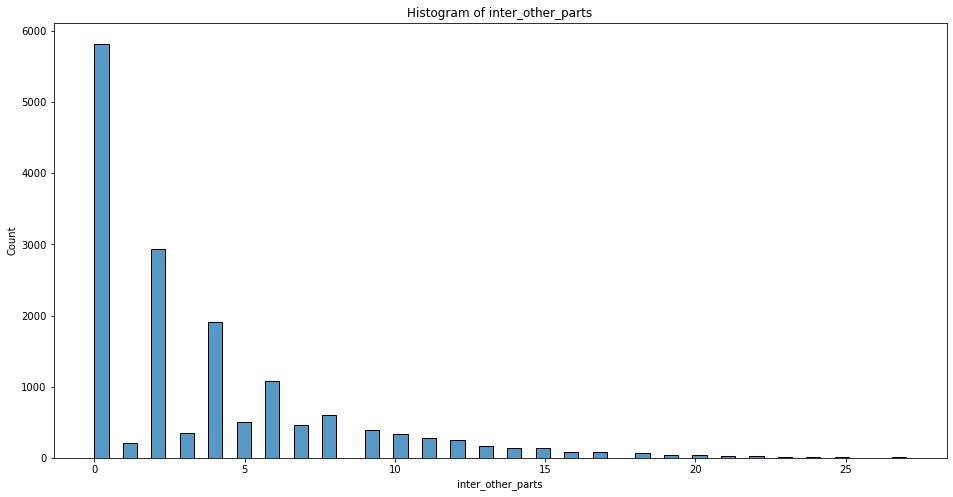

In [32]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### non_zero_pixels

In [33]:
column_name = "non_zero_pixels"
print(descr_df.loc[column_name, "description"])

number of pixels different from 0 after encoding the block.


<AxesSubplot:title={'center':'Histogram of non_zero_pixels'}, xlabel='non_zero_pixels', ylabel='Count'>

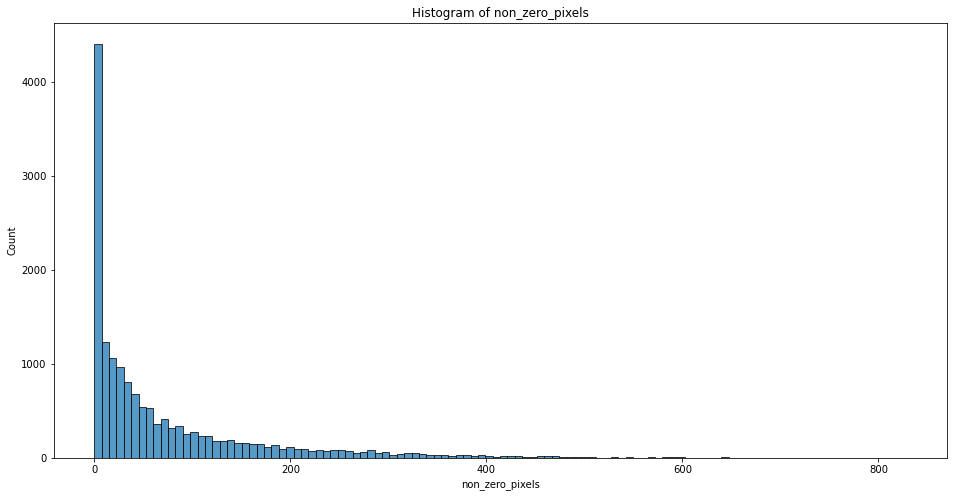

In [34]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### frame_width

In [35]:
column_name = "frame_width"
print(descr_df.loc[column_name, "description"])

the width of the video frame in pixels.


<AxesSubplot:title={'center':'Histogram of frame_width'}, xlabel='frame_width', ylabel='Count'>

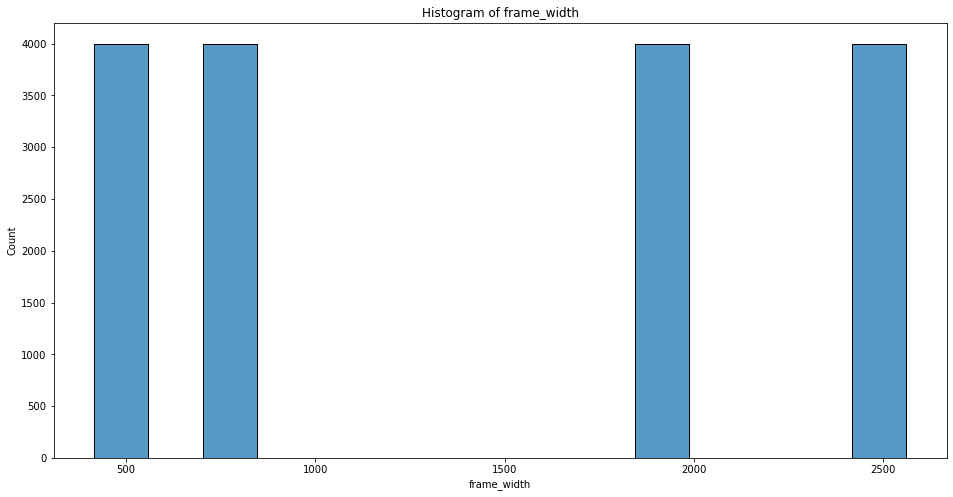

In [36]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### frame_height

In [37]:
column_name = "frame_height"
print(descr_df.loc[column_name, "description"])

the height of the video frame in pixels.


<AxesSubplot:title={'center':'Histogram of frame_height'}, xlabel='frame_height', ylabel='Count'>

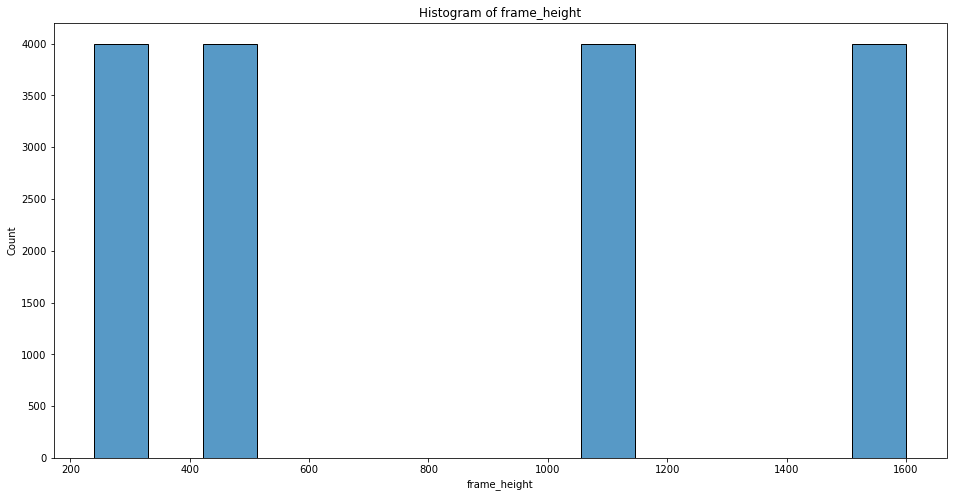

In [38]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### movement_level

In [39]:
column_name = "movement_level"
print(descr_df.loc[column_name, "description"])

a measure of the level of movement of this frame with respect the previous one.


<AxesSubplot:title={'center':'Histogram of movement_level'}, xlabel='movement_level', ylabel='Count'>

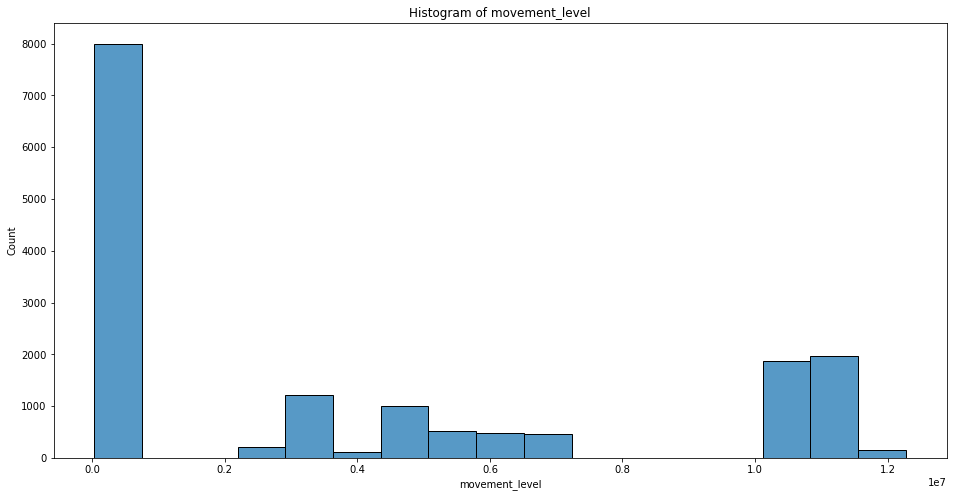

In [40]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### mean

In [41]:
column_name = "mean"
print(descr_df.loc[column_name, "description"])

mean of the pixels of the encoded block.


<AxesSubplot:title={'center':'Histogram of mean'}, xlabel='mean', ylabel='Count'>

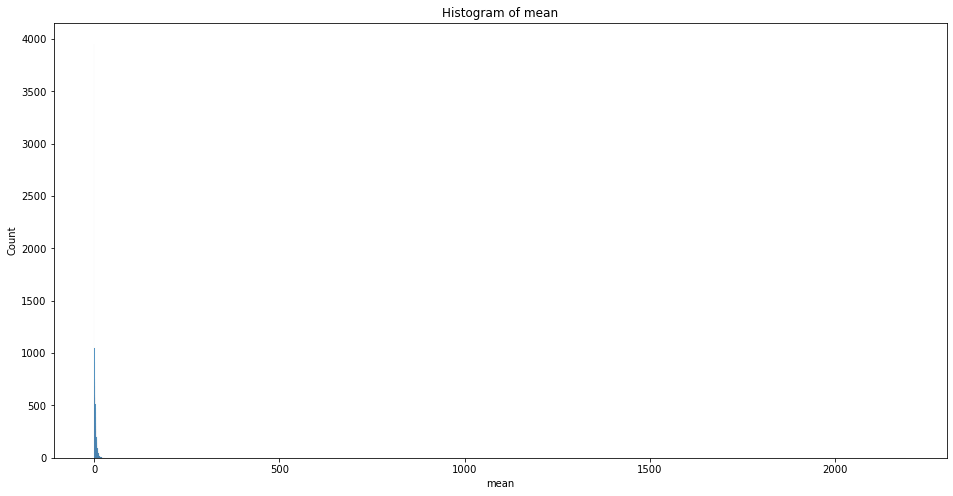

In [42]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_1

In [43]:
column_name = "sub_mean_1"
print(descr_df.loc[column_name, "description"])

mean of the pixels contained in the first 32x32 sub-bock of the current block.


<AxesSubplot:title={'center':'Histogram of sub_mean_1'}, xlabel='sub_mean_1', ylabel='Count'>

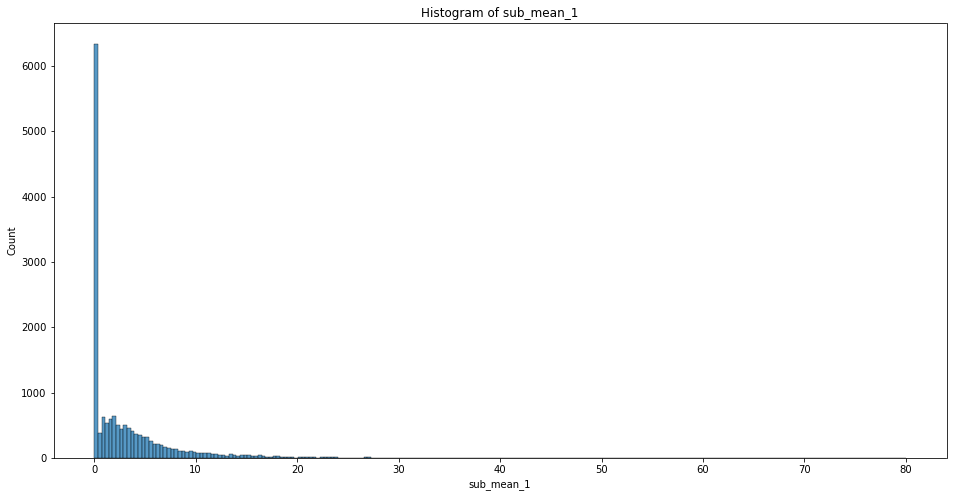

In [44]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_2

In [45]:
column_name = "sub_mean_2"
print(descr_df.loc[column_name, "description"])

mean of the pixels contained in the second 32x32 sub-bock of the current block.


<AxesSubplot:title={'center':'Histogram of sub_mean_2'}, xlabel='sub_mean_2', ylabel='Count'>

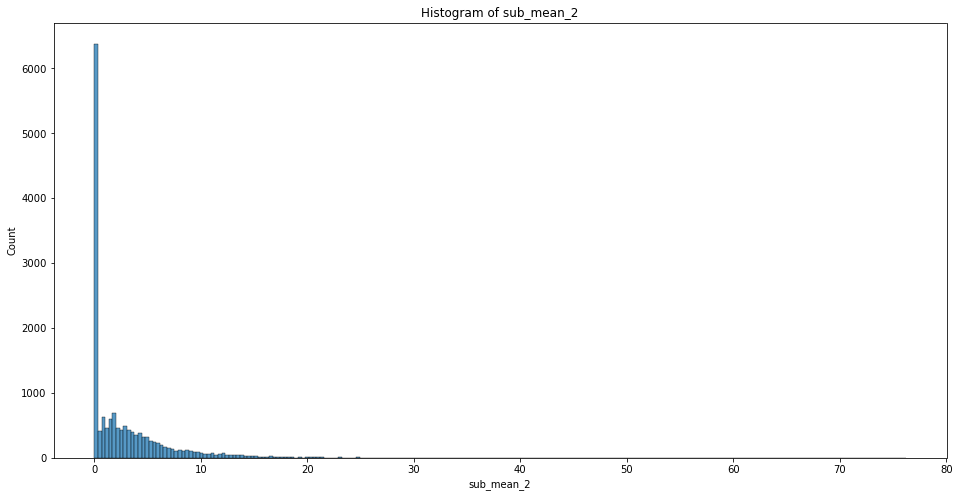

In [46]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_3

In [47]:
column_name = "sub_mean_3"
print(descr_df.loc[column_name, "description"])

mean of the pixels contained in the third 32x32 sub-bock of the current block.


<AxesSubplot:title={'center':'Histogram of sub_mean_3'}, xlabel='sub_mean_3', ylabel='Count'>

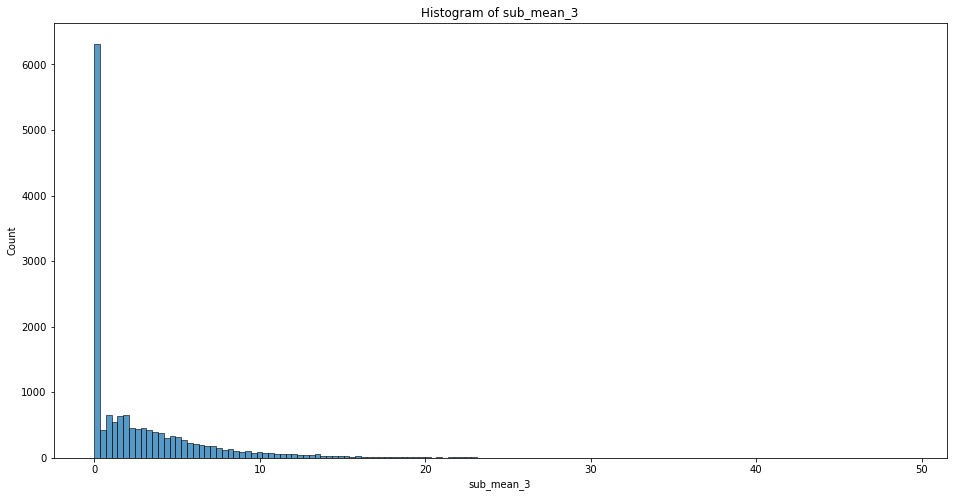

In [48]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sub_mean_4

In [49]:
column_name = "sub_mean_4"
print(descr_df.loc[column_name, "description"])

mean of the pixels contained in the fourth 32x32 sub-bock of the current block.


<AxesSubplot:title={'center':'Histogram of sub_mean_4'}, xlabel='sub_mean_4', ylabel='Count'>

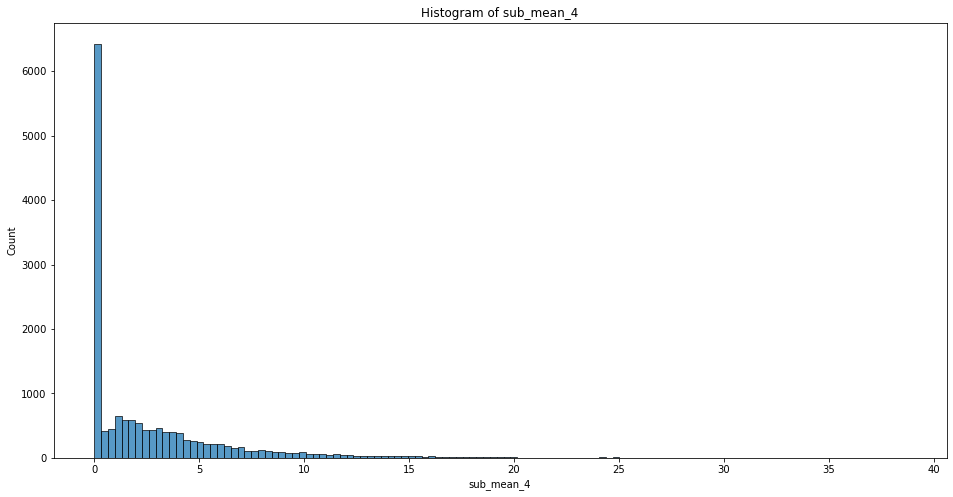

In [50]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### var_sub_blocks

In [51]:
column_name = "var_sub_blocks"
print(descr_df.loc[column_name, "description"])

variance of the four previous values.


<AxesSubplot:title={'center':'Histogram of var_sub_blocks'}, xlabel='var_sub_blocks', ylabel='Count'>

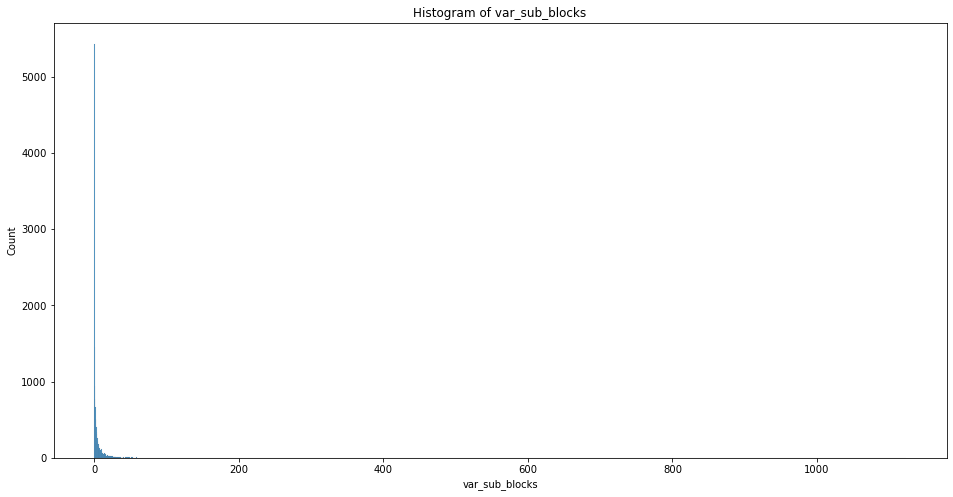

In [52]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sobel_h

In [53]:
column_name = "sobel_h"
print(descr_df.loc[column_name, "description"])

mean of the pixels of the encoded block after applying the Sobel operator in horizontal direction.


<AxesSubplot:title={'center':'Histogram of sobel_h'}, xlabel='sobel_h', ylabel='Count'>

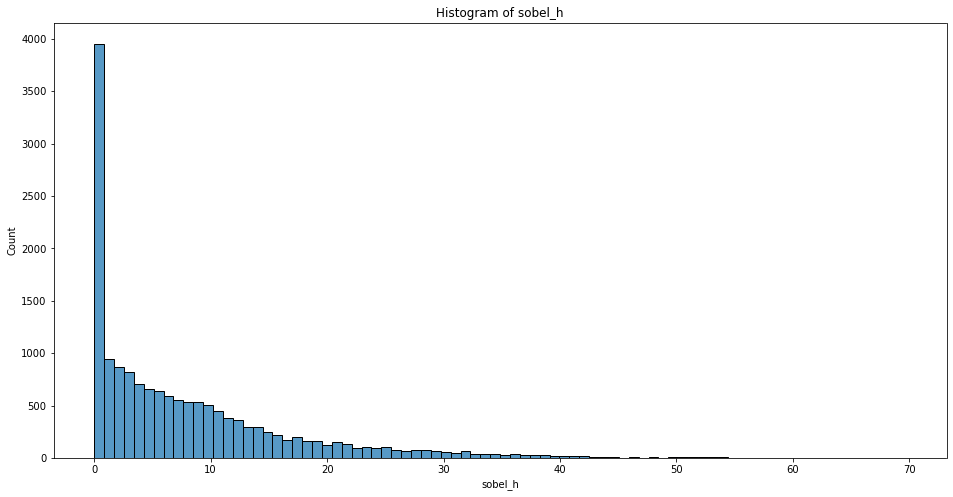

In [54]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### sobel_v

In [55]:
column_name = "sobel_v"
print(descr_df.loc[column_name, "description"])

mean of the pixels of the encoded block after applying the Sobel operator in vertical direction.


<AxesSubplot:title={'center':'Histogram of sobel_v'}, xlabel='sobel_v', ylabel='Count'>

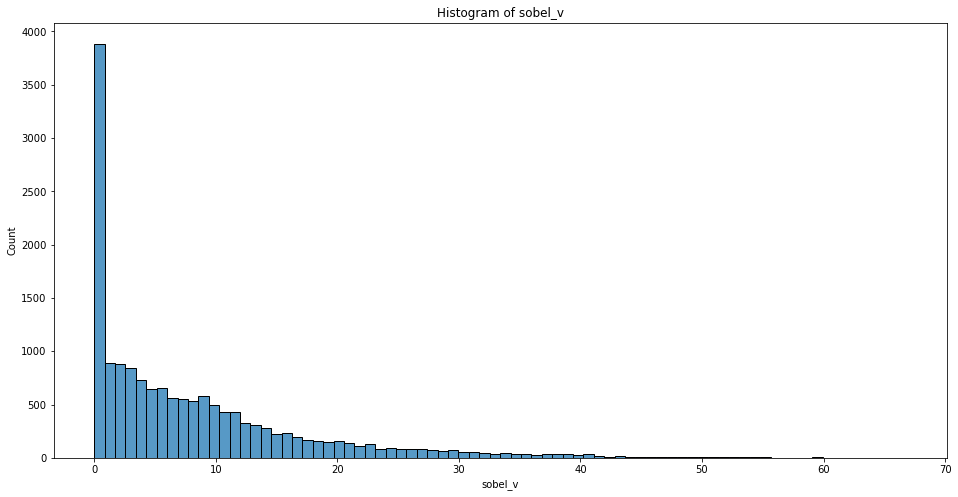

In [56]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### variance

In [57]:
column_name = "variance"
print(descr_df.loc[column_name, "description"])

variance of the pixels of the encoded block.


<AxesSubplot:title={'center':'Histogram of variance'}, xlabel='variance', ylabel='Count'>

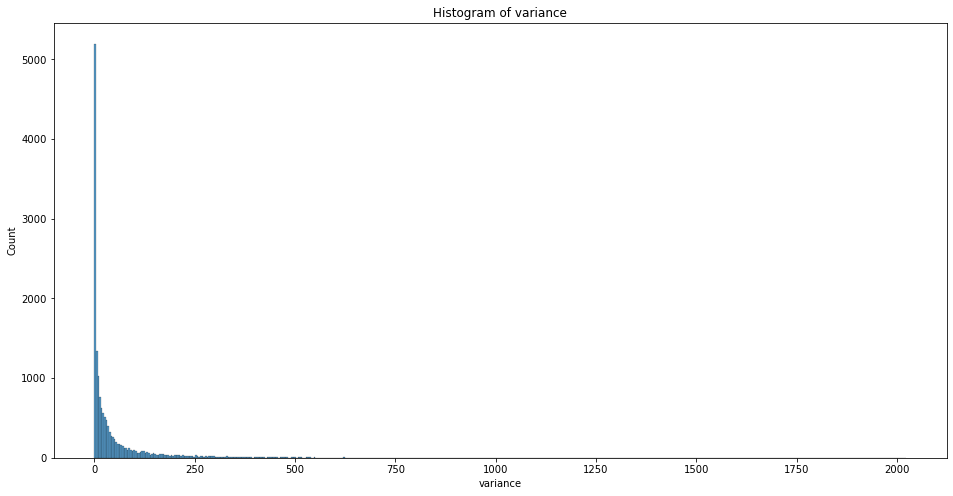

In [58]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### block_movement_h

In [59]:
column_name = "block_movement_h"
print(descr_df.loc[column_name, "description"])

a measure of the movement of the current block in the horizontal direction.


<AxesSubplot:title={'center':'Histogram of block_movement_h'}, xlabel='block_movement_h', ylabel='Count'>

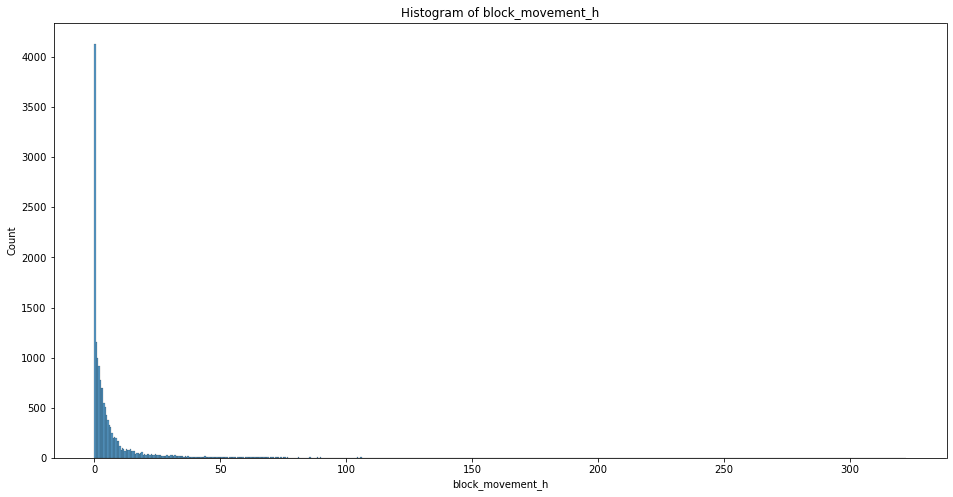

In [60]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### block_movement_v

In [61]:
column_name = "block_movement_v"
print(descr_df.loc[column_name, "description"])

a measure of the movement of the current block in the vertical direction.


<AxesSubplot:title={'center':'Histogram of block_movement_v'}, xlabel='block_movement_v', ylabel='Count'>

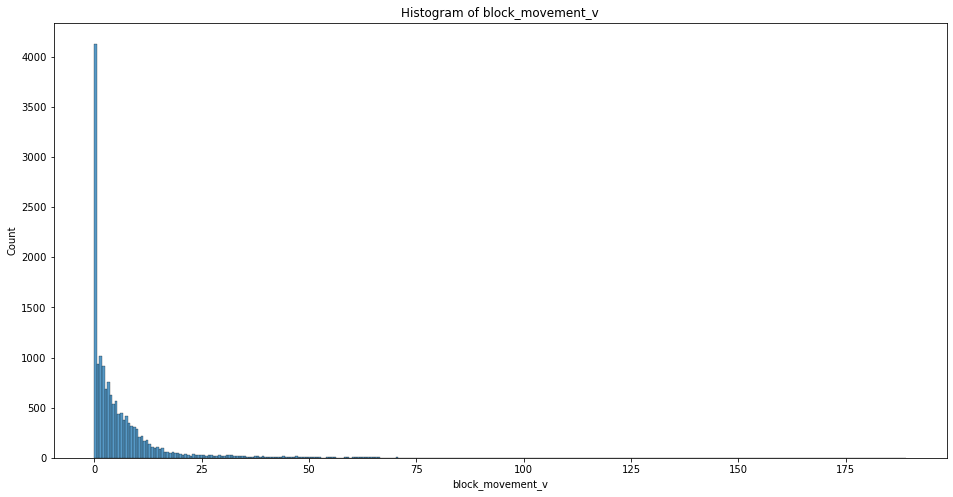

In [62]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### var_movement_h

In [63]:
column_name = "var_movement_h"
print(descr_df.loc[column_name, "description"])

a measure of the variance of the movements inside the current block in the horizontal direction.


<AxesSubplot:title={'center':'Histogram of var_movement_h'}, xlabel='var_movement_h', ylabel='Count'>

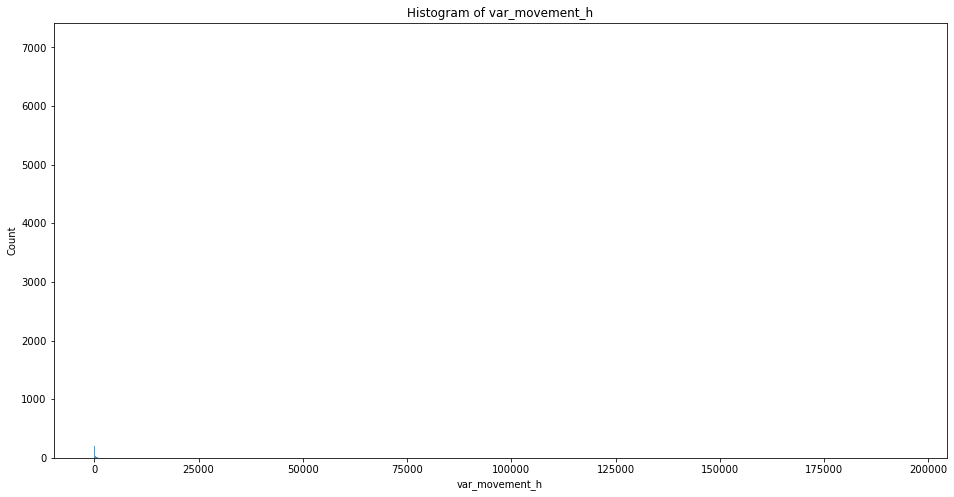

In [64]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### var_movement_v

In [65]:
column_name = "var_movement_v"
print(descr_df.loc[column_name, "description"])

a measure of the variance of the movements inside the current block in the vertical direction.


<AxesSubplot:title={'center':'Histogram of var_movement_v'}, xlabel='var_movement_v', ylabel='Count'>

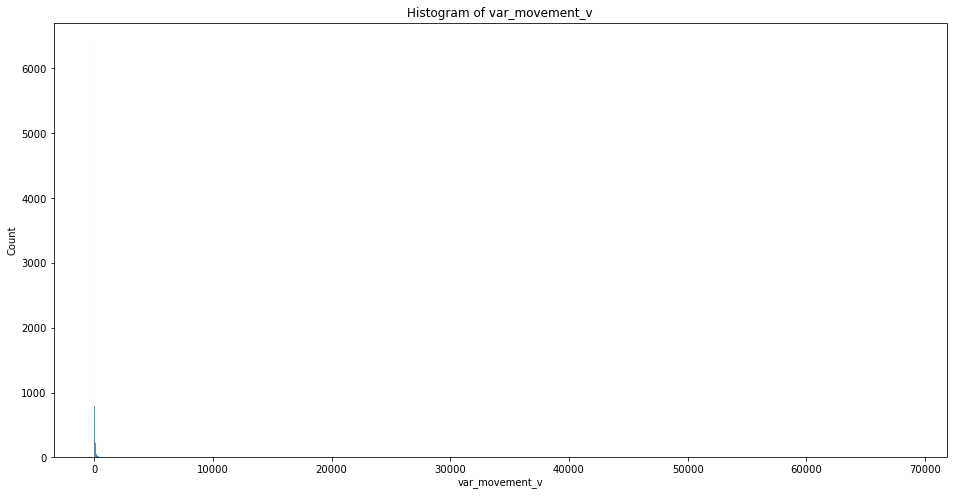

In [66]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### cost_1

In [67]:
column_name = "cost_1"
print(descr_df.loc[column_name, "description"])

a measure of the cost of encoding this block without partitioning it.


<AxesSubplot:title={'center':'Histogram of cost_1'}, xlabel='cost_1', ylabel='Count'>

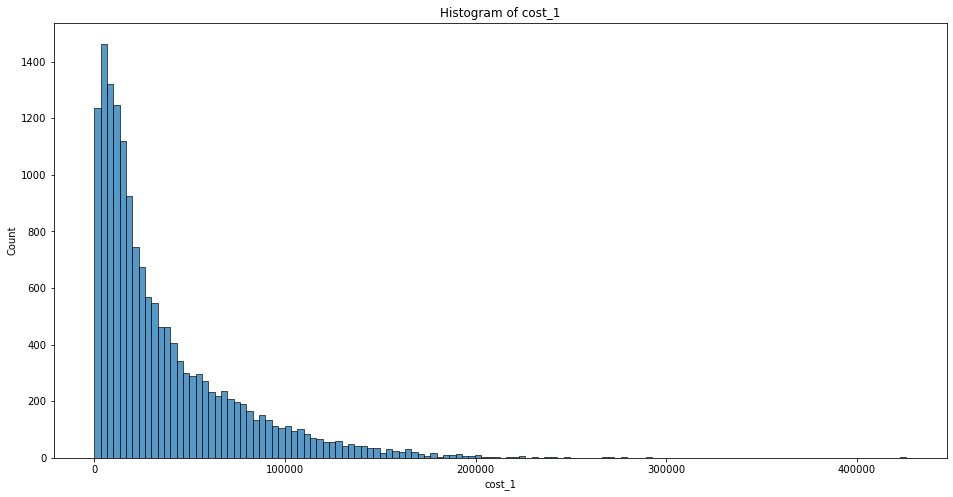

In [68]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

#### cost_2

In [69]:
column_name = "cost_2"
print(descr_df.loc[column_name, "description"])

a measure of the cost of encoding this block without partitioning it and without considering any movement in it.


<AxesSubplot:title={'center':'Histogram of cost_2'}, xlabel='cost_2', ylabel='Count'>

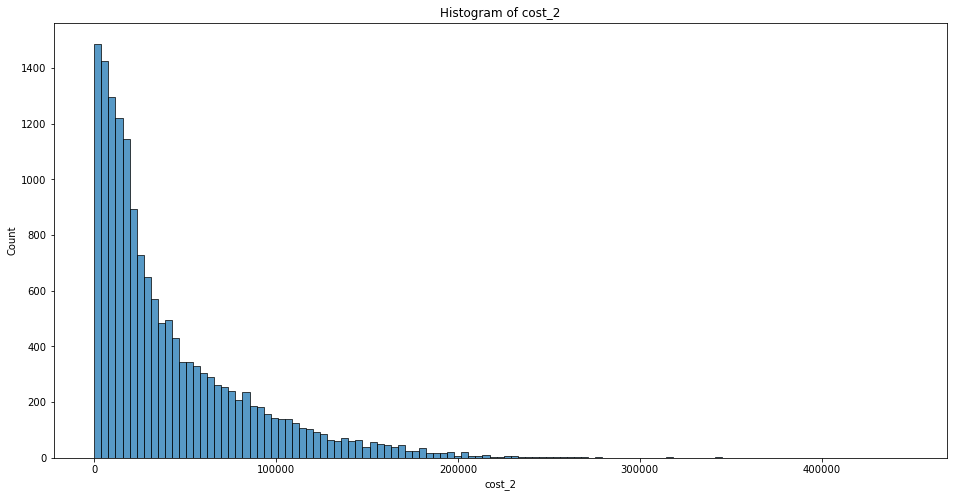

In [70]:
fig, ax = plt.subplots(figsize=(16,8))

ax.set_title(f"Histogram of {column_name}")
sns.histplot(df[column_name])

### Target variable: relevant 

In [71]:
column_name = "relevant"
print(descr_df.loc[column_name, "description"])

the target variable that indicates whether the current block is relevant (1) or not (0)


In [72]:
print("Relevant == 1: ", len(df[df.relevant == 1]))
print("Relevant == 0: ", len(df[df.relevant == 0]))

print("Percentage where relevant is 1 out of all: ",len(df[df.relevant == 1])/ len(df))

Relevant == 1:  13156
Relevant == 0:  2842
Percentage where relevant is 1 out of all:  0.8223527940992624


Conclusion of relevant:

There is a high difference in the number of relevant blocks and irrelevant blocks. In the machine learning we may need to stratify the data to not favor the algorithm of predicting 1 all the time. If we do not take this into account, we can create a very simple algorithm already with 82% accuracy (just predict 1 all the time).

As the outcome variable is binary, we should look into methods of classification, e.g. logistic regression / decision tree / neural networks

In order to consider which variables should be constant and categorical we explore the number of unique values of each of them

In [73]:
df.nunique()

quality                  4
bits                  2105
intra_parts             15
skip_parts               5
inter_16x16_parts        5
inter_4x4_parts         12
inter_other_parts       28
non_zero_pixels        568
frame_width              4
frame_height             4
movement_level         205
mean                  6598
sub_mean_1            3123
sub_mean_2            3022
sub_mean_3            3072
sub_mean_4            2975
var_sub_blocks       11455
sobel_h               9907
sobel_v               9894
variance             11999
block_movement_h      2368
block_movement_v      2221
var_movement_h        8426
var_movement_v        8449
cost_1               14377
cost_2               14536
relevant                 2
dtype: int64

We split into continuous and constant variables

In [74]:
cat = df.loc[:, df.nunique() < 29]
cont = df.loc[:, df.nunique() >= 29]
varlist = cont.columns.tolist()
varlist.append('relevant')
contRelv = df[varlist]

In [75]:
contRelv.groupby('relevant').mean()

,bits,non_zero_pixels,movement_level,mean,sub_mean_1,sub_mean_2,sub_mean_3,sub_mean_4,var_sub_blocks,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2
relevant,,,,,,,,,,,,,,,,,,
0.0,151.527094,21.776918,4.857270e+06,1.579388,1.772326,1.684585,1.589222,1.271418,4.234237,4.183534,4.216856,29.598292,7.685221,5.121575,977.899925,411.026926,30345.427164,34941.264344
1.0,514.109076,85.353147,3.856880e+06,3.874461,3.441059,3.225339,3.346922,3.189547,7.055798,8.857525,9.146477,58.460886,8.097799,7.159843,812.707176,509.461132,38368.758969,43593.241172


In this table we can check the difference between the relevant categories, which looks significative

We save a copy of the main dataframe for further analysis.

In [76]:
dftest=df

In [77]:
def equal_test(df, variables, y):
    for var in variables:
        group0 = df.loc[df[y] == 0][var].tolist()
        group1 = df.loc[df[y] == 1][var].tolist()
        print(var)
        # Some variables have different length depending the group
        maxSize = max(len(group0), len(group1))
        group0 = random.choices(group0, k = maxSize)
        group1 = random.choices(group1, k = maxSize)
        
        if ttest_rel(group0, group1).pvalue >= 0.5:
            print("The groups have the same mean.") 
        else:
            print("The groups are different.")

With this function we make use of the T-test in order to confirm if the groups are statistically different

In [78]:
equal_test(contRelv, contRelv.columns[:-1].tolist(), contRelv.columns[-1])

bits
The groups are different.
non_zero_pixels
The groups are different.
movement_level
The groups are different.
mean
The groups are different.
sub_mean_1
The groups are different.
sub_mean_2
The groups are different.
sub_mean_3
The groups are different.
sub_mean_4
The groups are different.
var_sub_blocks
The groups are different.
sobel_h
The groups are different.
sobel_v
The groups are different.
variance
The groups are different.
block_movement_h
The groups are different.
block_movement_v
The groups are different.
var_movement_h
The groups are different.
var_movement_v
The groups are different.
cost_1
The groups are different.
cost_2
The groups are different.


Now we can see how the categorical variables correlate with the relevant variable

<AxesSubplot:>

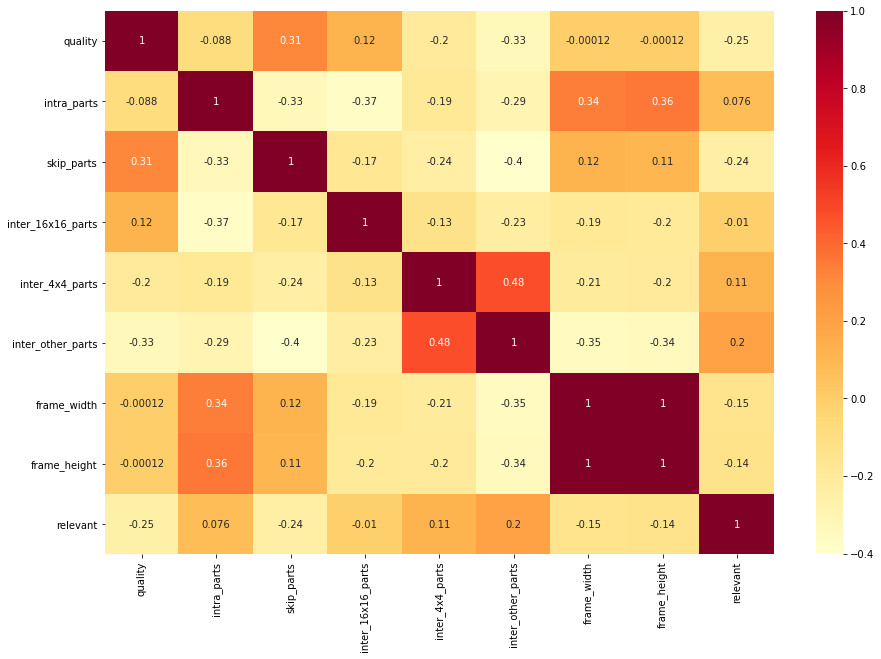

In [79]:
plt.figure(figsize = (15, 10))
corr_mtx = cat.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

Now we do the same with the continuous variables

<AxesSubplot:>

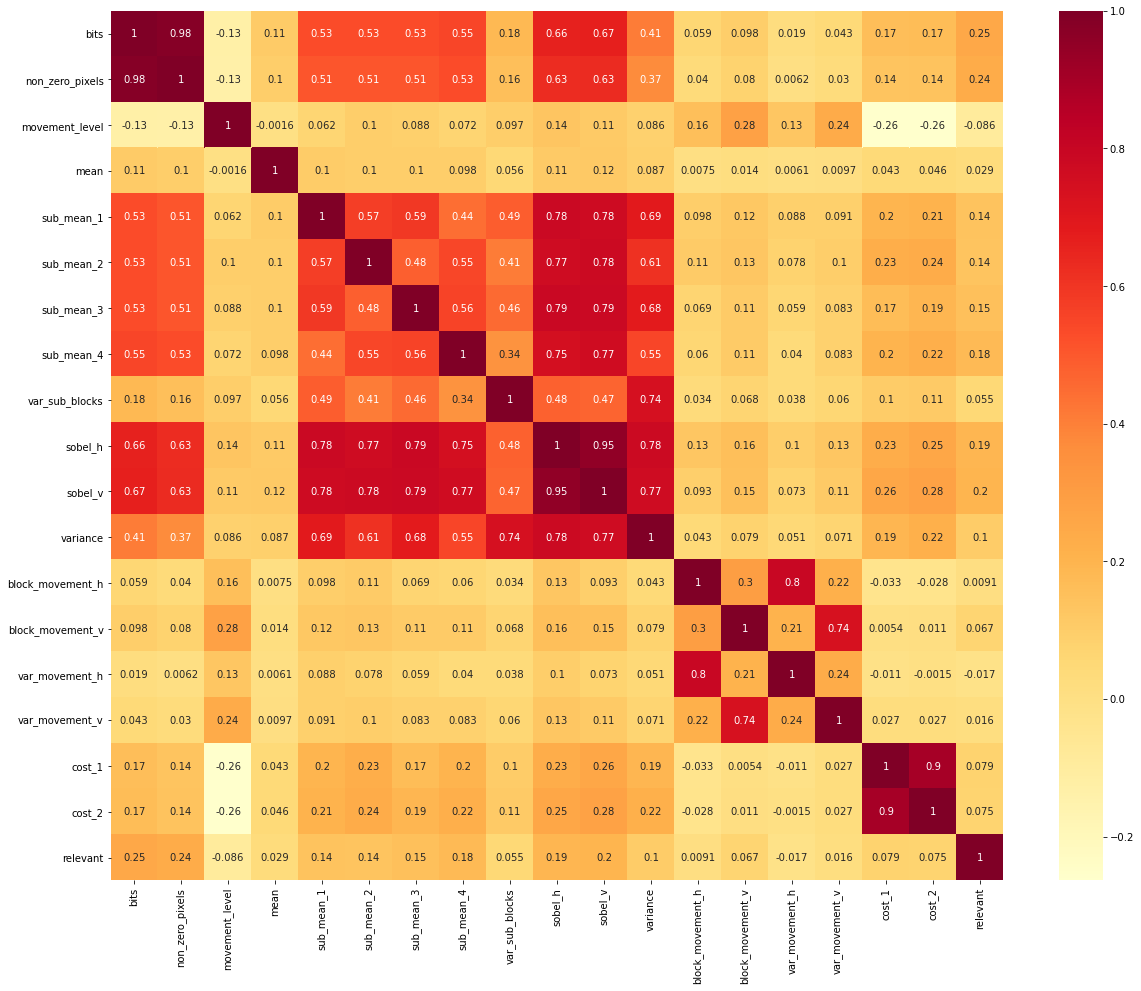

In [80]:
plt.figure(figsize = (20, 16))
corr_mtx = contRelv.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

We reduce the number of variables in order to make a more comprenhensive correlation analysis.
Some of the variables are highly correlated and their descriptions help to understand how this reductions can me done. After creating new variables we delete the old ones.

In the first case we generate a new variable combining frame_height, frame_width and non_zero_pixels in order to obtain precise pixel infromation of the frame.

In [81]:
df["pixel_frame"] = df['non_zero_pixels'] / (df['frame_height'] * df['frame_width'])

df = df.drop(['frame_height', 'frame_width', 'non_zero_pixels'], axis = 1)

For the sub_mean variable we have put all of them together in order to reduce their correlation.

In [82]:
df['sub_mean'] = (df['sub_mean_1'] + df['sub_mean_2'] + df['sub_mean_3'] + df['sub_mean_4']) / 4

df = df.drop(['sub_mean_1', 'sub_mean_2', 'sub_mean_3', 'sub_mean_4'], axis = 1)

The sobel variables make reference to the mean of the pixels of the encoded block after applying the Sobel operator in vertical and horizontal direction. So we can combine them easily in order to obtain a mean of both of them.

In [83]:
df['sobel_hv'] = (df['sobel_h'] + df['sobel_v']) / 2

df = df.drop(['sobel_h', 'sobel_v'], axis = 1)

This variables make reference to the measure of the movement and variance of a certain block in vertical and horizontal. As it is not relevant for this project to keep them separated we can obtain a single variable collecting a mean of this information.

In [84]:
df['movement_var'] = ((df['block_movement_h'] / df['var_movement_h']) + (df['block_movement_v'] / df['var_movement_v'])) / 2

df = df.drop(['block_movement_h', 'block_movement_v', 'var_movement_h', 'var_movement_v'], axis = 1)

We make the same combination with the cost variables so we can obtain a better correlation analysis.

In [85]:
df['cost'] = (df['cost_1'] + df['cost_2']) / 2

df = df.drop(['cost_1', 'cost_2'], axis = 1)

Now we can check if the correlation have been improved with the transformed variables.

<AxesSubplot:>

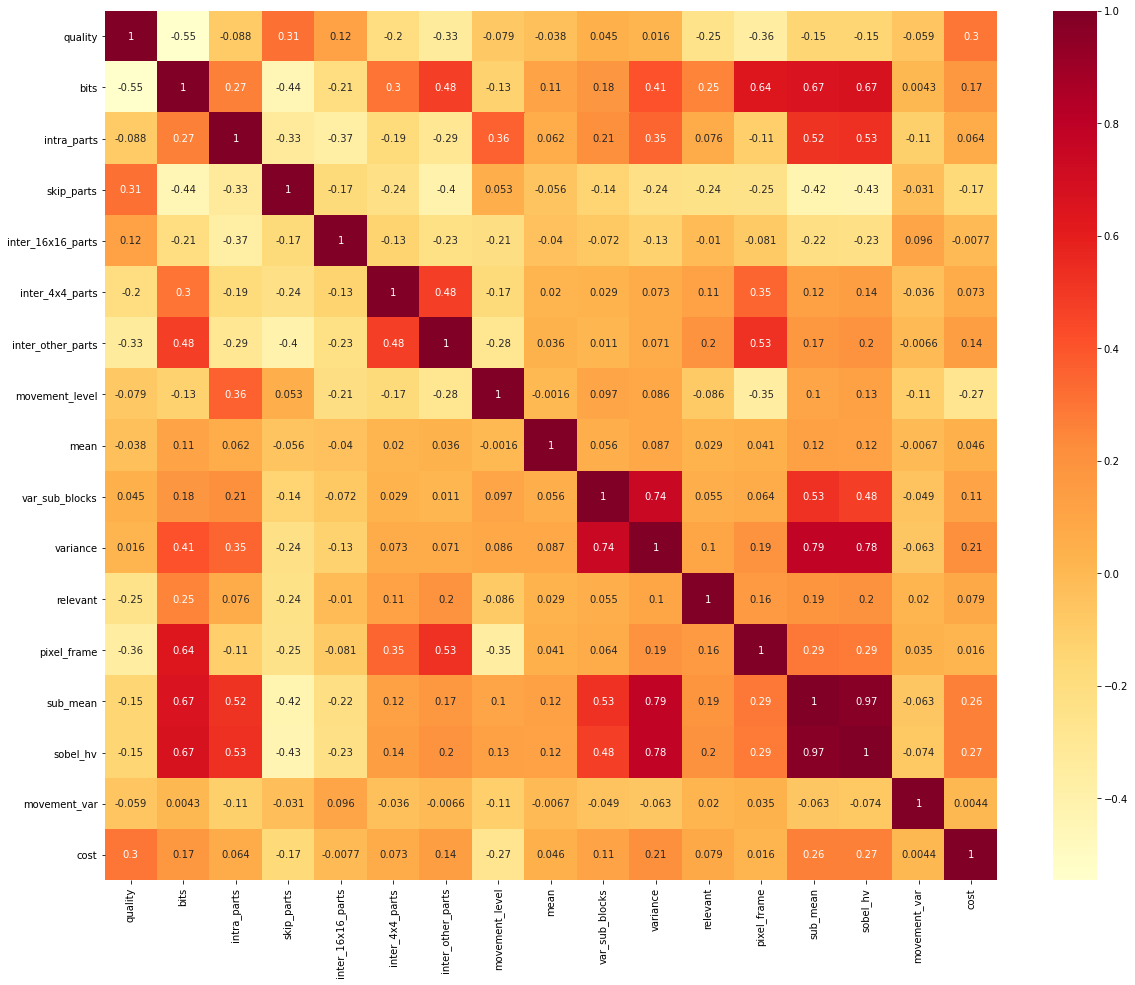

In [86]:
plt.figure(figsize = (20, 16))
corr_mtx = df.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

By checking the correlation we can reduce the number of variables but the main method used in this project works under the SelectKBest function.

In this part the analysis is not finished since some variables still having high correlation between them (<0.5). Due that we have decided to drop sobel_hv, sub_mean, variance, bits and inter_other_parts.

In [87]:
df = df.drop(["sobel_hv", "sub_mean", "variance", "bits", "inter_other_parts"], axis = 1)

Now we generate the correlation matrix showing the improvement of the results for the target variable.

<AxesSubplot:>

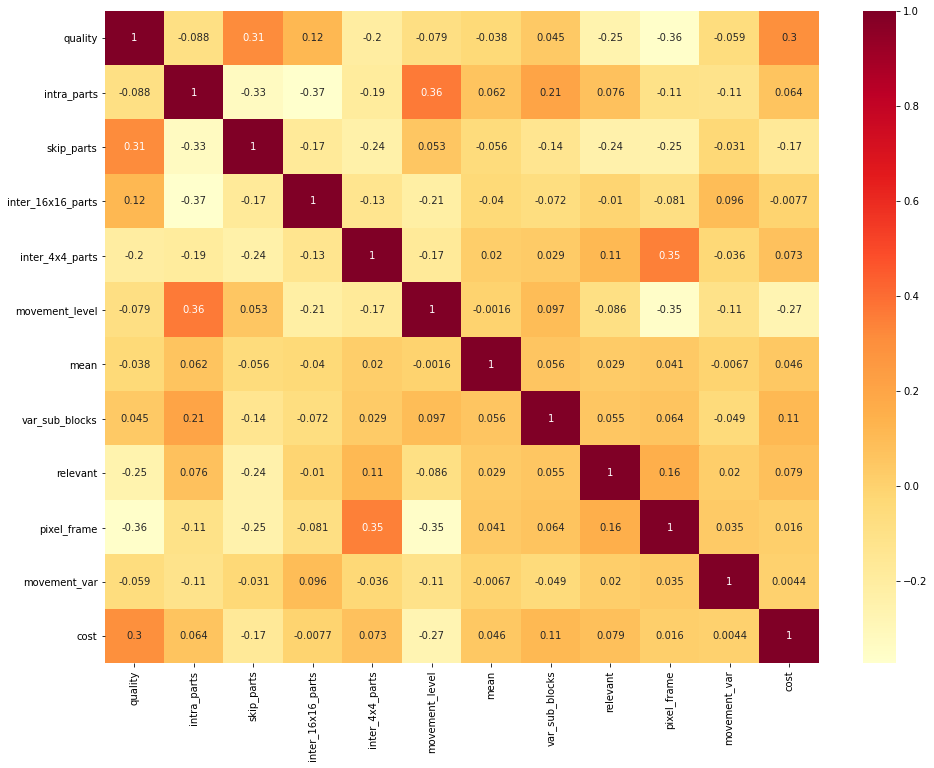

In [88]:
plt.figure(figsize = (16, 12))
corr_mtx = df.corr()
sns.heatmap(corr_mtx, annot = True, cmap = "YlOrRd")

Now we can check if the continuous variables that are still in the analysis are statistically different or if they have the same mean.

In [89]:
cont = df.loc[:, df.nunique() >= 29]
varlist = cont.columns.tolist()
varlist.append('relevant')
contRelv = df[varlist]
equal_test(contRelv, ["movement_level", "mean", "var_sub_blocks", "pixel_frame", "cost", "movement_var"], contRelv.columns[-1])

movement_level
The groups are different.
mean
The groups are different.
var_sub_blocks
The groups are different.
pixel_frame
The groups are different.
cost
The groups are different.
movement_var
The groups are different.


We decided to use the Label encoder instead of the One Hot Encoding as order could be important for further analysis.

In [90]:
cat.head()

,quality,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,frame_width,frame_height,relevant
0,22,0,0,1,3,21,416,240,1.0
1,22,0,2,0,3,8,416,240,1.0
2,22,0,0,0,0,8,416,240,1.0
3,22,0,0,0,18,20,416,240,1.0
4,22,0,0,1,3,8,416,240,1.0


In [91]:
l_code = LabelEncoder()
for var in cat.columns:
    l_code.fit(cat[var])
    cat[var] = l_code.transform(cat[var])

<ipython-input-91-2d4273d8aac2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat[var] = l_code.transform(cat[var])


In [92]:
cat.head()

,quality,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,frame_width,frame_height,relevant
0,0,0,0,1,1,21,0,0,1
1,0,0,2,0,1,8,0,0,1
2,0,0,0,0,0,8,0,0,1
3,0,0,0,0,6,20,0,0,1
4,0,0,0,1,1,8,0,0,1


In order to perform the SelectKBest method it is necessary to delete the the Missing Values.

In [93]:
dftest = dftest[~dftest.sub_mean_3.isnull()]

dftest = dftest[~dftest.cost_2.isnull()]

In this step we create feature and target variable for Classification problem

In [94]:
X_clf = dftest.loc[:,dftest.columns != 'relevant']

y_clf = dftest.loc[:,dftest.columns == 'relevant']

X_clf_new = SelectKBest(score_func = chi2, k = 10).fit_transform(X_clf, y_clf)

X_clf_new[:5]

array([[2.14300000e+03, 4.04000000e+02, 4.16000000e+02, 2.40000000e+02,
        4.23520000e+04, 8.75843350e+01, 1.07724000e+01, 8.57659900e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.73500000e+03, 3.81000000e+02, 4.16000000e+02, 2.40000000e+02,
        4.23520000e+04, 4.80253300e+01, 6.16308600e+00, 6.66577100e+00,
        8.81600000e+03, 8.80100000e+03],
       [1.97100000e+03, 4.60000000e+02, 4.16000000e+02, 2.40000000e+02,
        4.23520000e+04, 5.66134800e+01, 1.62500000e+00, 3.68359400e+00,
        5.10400000e+03, 5.19300000e+03],
       [2.47300000e+03, 4.21000000e+02, 4.16000000e+02, 2.40000000e+02,
        4.23520000e+04, 2.83079285e+02, 2.58063960e+01, 3.46562500e+01,
        2.15310000e+04, 1.98020000e+04],
       [1.09300000e+03, 1.67000000e+02, 4.16000000e+02, 2.40000000e+02,
        4.23520000e+04, 1.75123245e+02, 2.22528690e+01, 1.47807010e+01,
        1.50730000e+04, 1.45490000e+04]])

In [95]:
X_clf.head()

,quality,bits,intra_parts,skip_parts,inter_16x16_parts,inter_4x4_parts,inter_other_parts,non_zero_pixels,frame_width,frame_height,...,sobel_h,sobel_v,variance,block_movement_h,block_movement_v,var_movement_h,var_movement_v,cost_1,cost_2,pixel_frame
0,22,2143,0,0,1,3,21,404,416,240,...,17.397461,17.397461,87.584335,2.820312,2.539062,10.772400,8.576599,0.0,0.0,0.004046
1,22,1735,0,2,0,3,8,381,416,240,...,14.426758,14.233398,48.025330,1.843750,1.921875,6.163086,6.665771,8816.0,8801.0,0.003816
2,22,1971,0,0,0,0,8,460,416,240,...,15.203125,13.953125,56.613480,3.000000,4.937500,1.625000,3.683594,5104.0,5193.0,0.004607
3,22,2473,0,0,0,18,20,421,416,240,...,21.725586,29.165039,283.079285,2.078125,2.500000,25.806396,34.656250,21531.0,19802.0,0.004217
4,22,1093,0,0,1,3,8,167,416,240,...,11.929688,14.353516,175.123245,3.070312,4.523438,22.252869,14.780701,15073.0,14549.0,0.001673


We can conclude that the best 10 features that classify the most with the target variable relevant are bits, non_zero_pixels, frame_width, frame_height, movement_level, variance, var_movement_h, var_movement_v, cost_1 and cost_2.